In [1]:
import pandas as pd
import re 
import numpy as np
import ast
import math
from sklearn import metrics 
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
dfstruct=pd.read_csv("lowva/ben_predictions/struct02_lowva_preds-8143.csv", header=None)
dfcombo=pd.read_csv("lowva/ben_predictions/pubmed_combo15_lowva_preds-8336.csv", header=None)

In [3]:
def preprocessdf(df): 
    df.columns=["predictions", "label"]
    proba=df["predictions"].tolist()
    y=df["label"].tolist() 
    return y, proba

In [4]:
def returnauc(df):
    fpr, tpr, thresholds = metrics.roc_curve(*preprocessdf(df), pos_label=1)
    auc=metrics.auc(fpr, tpr)
    return auc

In [5]:
returnauc(dfstruct)

0.7907767213265353

In [6]:
def returnfprtpr(df):
    fpr, tpr, thresholds = metrics.roc_curve(*preprocessdf(df), pos_label=1)
    return fpr, tpr

In [7]:
from sklearn import metrics 
fpr, tpr, thresholds = metrics.roc_curve(*preprocessdf(dfstruct), pos_label=1)
auc=metrics.auc(fpr, tpr)
auc


0.7907767213265353

<Figure size 432x288 with 0 Axes>

(<matplotlib.collections.PathCollection at 0x21ab603cd68>,)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Curve ')

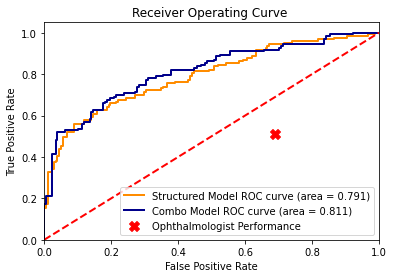

In [8]:
plt.figure()
lw = 2

plt.plot(*returnfprtpr(dfstruct), color='darkorange',
         lw=lw, label='Structured Model ROC curve (area = %0.3f)' % returnauc(dfstruct))
plt.plot(*returnfprtpr(dfcombo), color='darkblue',
         lw=lw, label='Combo Model ROC curve (area = %0.3f)' % returnauc(dfcombo))
plt.scatter(0.69, 1-0.49, 
            color="red", marker="X", s=100, label = 'Ophthalmologist Performance'),
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve ')
plt.legend(loc="lower right")
plt.show()

In [9]:
def returnauprc(df):
    precision, recall, thresholds=metrics.precision_recall_curve(*preprocessdf(df), pos_label=1)
    return metrics.auc(recall, precision)
returnauprc(dfstruct)

0.7726562716093142

In [10]:
def returnrecallprecision(df): 
    precision, recall, thresholds=metrics.precision_recall_curve(*preprocessdf(df), pos_label=1)
    return recall, precision

<Figure size 432x288 with 0 Axes>

(<matplotlib.collections.PathCollection at 0x21ab63aa940>,)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision Recall Curve')

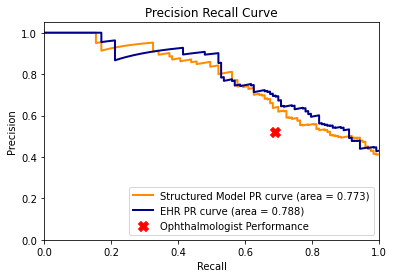

In [11]:
plt.figure()
lw = 2
plt.plot(*returnrecallprecision(dfstruct), color='darkorange',
         lw=lw, label='Structured Model PR curve (area = %0.3f)' % returnauprc(dfstruct))
plt.plot(*returnrecallprecision(dfcombo), color='darkblue', lw=lw, label='EHR PR curve (area = %0.3f)' % returnauprc(dfcombo))
plt.scatter(0.69, 0.52, 
            color="red", marker="X", s=100, label = 'Ophthalmologist Performance'),
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
def getpredictions(df,threshold=0.5): 
    Y , proba = preprocessdf(df)
    predictions=np.where(np.array(proba)>threshold, 1,0)
    return Y, list(predictions)

In [13]:
print(metrics.classification_report(*getpredictions(dfstruct)))
print(metrics.classification_report(*getpredictions(dfcombo)))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       177
           1       0.73      0.63      0.67       123

    accuracy                           0.75       300
   macro avg       0.74      0.73      0.74       300
weighted avg       0.75      0.75      0.75       300

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       177
           1       0.67      0.71      0.69       123

    accuracy                           0.74       300
   macro avg       0.73      0.74      0.73       300
weighted avg       0.74      0.74      0.74       300



In [14]:
#calibration curve 
from sklearn.calibration import calibration_curve

def calibrationplot(df, name): 
    y, proba = preprocessdf(df)  
    fraction_of_positives, mean_predicted_value = calibration_curve(y, proba, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(proba, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    return 

<Figure size 720x720 with 0 Axes>

Text(0, 0.5, 'Fraction of Positives')

(-0.05, 1.05)

Text(0.5, 1.0, 'Calibration Plots')

Text(0.5, 0, 'Mean Predicted Value')

Text(0, 0.5, 'Count')

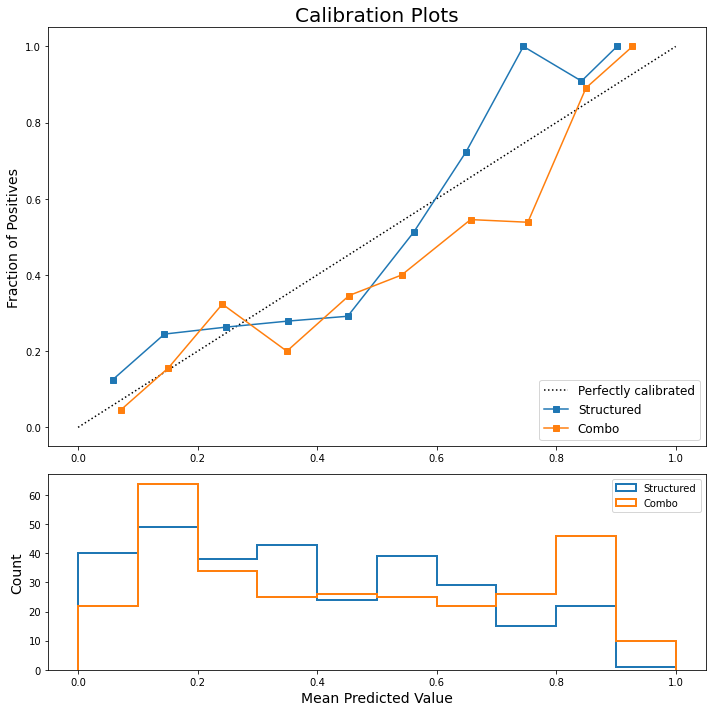

In [15]:
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for df, name in [(dfstruct, 'Structured'),
                 (dfcombo, 'Combo')]:
    calibrationplot(df, name)
ax1.set_ylabel("Fraction of Positives", fontsize=14)
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right", fontsize=12)
ax1.set_title('Calibration Plots', fontsize=20)

ax2.set_xlabel("Mean Predicted Value", fontsize=14)
ax2.set_ylabel("Count", fontsize=14)
ax2.legend(loc="upper right", ncol=1)

plt.tight_layout()
plt.show()